In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.metrics import mutual_info_score, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
%matplotlib inline

In [2]:
df = pd.read_csv('data.csv')
df.head()

,type_school,school_accreditation,gender,interest,residence,parent_age,parent_salary,house_area,average_grades,parent_was_in_college,in_college
0,Academic,A,Male,Less Interested,Urban,56,6950000,83.0,84.09,False,True
1,Academic,A,Male,Less Interested,Urban,57,4410000,76.8,86.91,False,True
2,Academic,B,Female,Very Interested,Urban,50,6500000,80.6,87.43,False,True
3,Vocational,B,Male,Very Interested,Rural,49,6600000,78.2,82.12,True,True
4,Academic,A,Female,Very Interested,Urban,57,5250000,75.1,86.79,False,False


In [3]:
df.isna().sum()

type_school              0
school_accreditation     0
gender                   0
interest                 0
residence                0
parent_age               0
parent_salary            0
house_area               0
average_grades           0
parent_was_in_college    0
in_college               0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   type_school            1000 non-null   object 
 1   school_accreditation   1000 non-null   object 
 2   gender                 1000 non-null   object 
 3   interest               1000 non-null   object 
 4   residence              1000 non-null   object 
 5   parent_age             1000 non-null   int64  
 6   parent_salary          1000 non-null   int64  
 7   house_area             1000 non-null   float64
 8   average_grades         1000 non-null   float64
 9   parent_was_in_college  1000 non-null   bool   
 10  in_college             1000 non-null   bool   
dtypes: bool(2), float64(2), int64(2), object(5)
memory usage: 72.4+ KB


In [5]:
df.in_college = df.in_college.astype(int)
df.parent_was_in_college = df.parent_was_in_college.astype(int)

In [6]:
num = ['parent_age', 'parent_salary', 'house_area']
cat = ['type_school', 'school_accreditation', 'gender', 'interest', 'residence', 'parent_was_in_college']

In [7]:
df.describe()

,parent_age,parent_salary,house_area,average_grades,parent_was_in_college,in_college
count,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.00000,1000.00000
mean,52.208000,5.381570e+06,74.515300,86.097200,0.52000,0.50000
std,3.500427,1.397546e+06,15.293346,3.378738,0.49985,0.50025
min,40.000000,1.000000e+06,20.000000,75.000000,0.00000,0.00000
25%,50.000000,4.360000e+06,64.600000,83.737500,0.00000,0.00000
50%,52.000000,5.440000e+06,75.500000,85.575000,1.00000,0.50000
75%,54.000000,6.382500e+06,84.825000,88.262500,1.00000,1.00000
max,65.000000,1.000000e+07,120.000000,98.000000,1.00000,1.00000


In [8]:
df.nunique()

type_school                2
school_accreditation       2
gender                     2
interest                   5
residence                  2
parent_age                25
parent_salary            461
house_area               472
average_grades           684
parent_was_in_college      2
in_college                 2
dtype: int64

<AxesSubplot:xlabel='in_college', ylabel='Count'>

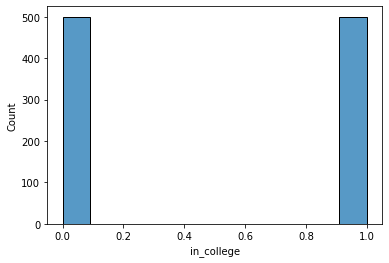

In [9]:
sns.histplot(df.in_college)

In [10]:
df_train_full, df_test = train_test_split(df, test_size = 0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size = 0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.in_college.values
y_val = df_val.in_college.values
y_test = df_test.in_college.values

del df_train['in_college']
del df_val['in_college']
del df_test['in_college']

In [11]:
for n in num:
    score = roc_auc_score(y_train, df_train[n])
    if score < 0.5:
        print(n, roc_auc_score(y_train, -df_train[n]))
    else:
        print(n, score)

parent_age 0.5224689135580226
parent_salary 0.7820948761542821
house_area 0.7625262526252624


In [12]:
df[num].corrwith(df.in_college)

parent_age       0.042873
parent_salary    0.475693
house_area       0.467267
dtype: float64

In [13]:
for c in cat:
    print(c, round(mutual_info_score(df[c], df.in_college), 3))

type_school 0.001
school_accreditation 0.0
gender 0.001
interest 0.038
residence 0.0
parent_was_in_college 0.001


In [14]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.fit_transform(val_dict)

# Logistic Regression

In [15]:
lr = LogisticRegression(random_state=1)
lr.fit(X_train, y_train)

y_pred = lr.predict_proba(X_val)[:, 1]
print(f'roc auc score: {roc_auc_score(y_val, y_pred)}')

roc auc score: 0.7903161264505801


# Parameter Tuning

In [16]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'max_iter' : range(1000,15001,1000)}

lr_v2 = GridSearchCV(lr, param_grid, cv=10, n_jobs=-1)
lr_v2.fit(X_train, y_train)

print('Best Parameters', lr_v2.best_params_)
y_pred = lr_v2.best_estimator_.predict_proba(X_val)[:, 1]

print(f'roc auc score: {roc_auc_score(y_val, y_pred)}')

Best Parameters {'C': 0.001, 'max_iter': 1000}
roc auc score: 0.7903161264505801


# Ridge Classifier

In [17]:
clf = RidgeClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)
print(f'roc auc score: {roc_auc_score(y_val, y_pred)}')

roc auc score: 0.8301320528211285


# Parameter Tuning

In [18]:
rd_parameters = {'normalize' : [True,False],
                'fit_intercept' : [True,False],
                'max_iter': [1000, 5000, 10000],
                'alpha': [0.5, 1, 1.5]
                }

clf_v2 = GridSearchCV(clf, rd_parameters, cv=10, n_jobs=-1)
clf_v2.fit(X_train, y_train)

print('Best Paraneters', clf_v2.best_params_)

y_pred = clf.predict(X_val)
print(f'roc auc score: {roc_auc_score(y_val, y_pred)}')

Best Paraneters {'alpha': 0.5, 'fit_intercept': True, 'max_iter': 1000, 'normalize': False}
roc auc score: 0.8301320528211285


# Decision Tree

In [19]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8599439775910365

# Parameter Tuning

In [20]:
parameters = {'max_depth' : [3,5,10,15],
              'min_samples_leaf' : [1,3,5,10,30,50]           
              }


dt_v2 = GridSearchCV(dt, parameters, cv=10, n_jobs=-1)
dt_v2.fit(X_train, y_train)

print('Best Paraneters', dt_v2.best_params_)

y_pred = dt_v2.best_estimator_.predict_proba(X_val)[:, 1]

print(f'roc auc score: {roc_auc_score(y_val, y_pred)}')

Best Paraneters {'max_depth': 15, 'min_samples_leaf': 1}
roc auc score: 0.8599439775910365


In [21]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8599439775910365

In [22]:
rf_parameters = {'max_depth' : [None,5,10,15,25],
                'min_samples_leaf' : [1,3,5,10,50],
                'n_estimators': np.arange(50,501,50)
                }


rf_v2 = GridSearchCV(rf, rf_parameters, cv=10, n_jobs=-1)
rf_v2.fit(X_train, y_train)

print('Best Paraneters', rf_v2.best_params_)

y_pred = rf_v2.best_estimator_.predict_proba(X_val)[:, 1]

print(f'roc auc score: {roc_auc_score(y_val, y_pred)}')

Best Paraneters {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}
roc auc score: 0.9664865946378551


# XGBoost classifier

In [23]:
model = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

[20:20:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




0.921468587434974

In [24]:
depth = [3, 4, 5, 7, 10, 15, 20]
learning_rates = [0.1, 0.01, 0.001]

l = []

for max_depth in depth:
    for learning_rate in learning_rates:
        model = XGBClassifier(silent=False, 
                          scale_pos_weight=1,
                          learning_rate=learning_rate,  
                          colsample_bytree = 0.4,
                          subsample = 0.8,
                          objective='binary:logistic', 
                          n_estimators=1000, 
                          reg_alpha = 0.3,
                          max_depth=max_depth, 
                          gamma=10)
        model.fit(X_train, y_train)

        y_pred = model.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, y_pred)
        l.append([max_depth, learning_rate, score])

[20:20:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:20:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:20:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false

[20:20:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [25]:
l = pd.DataFrame(l, columns=['max_depth', 'learning_rate', 'score'])
l.sort_values('score', ascending=False).head()

,max_depth,learning_rate,score
6,5,0.1,0.929672
0,3,0.1,0.927121
3,4,0.1,0.926871
12,10,0.1,0.924770
18,20,0.1,0.924770


# Best Model

In [26]:
df_train_full = df_train_full.reset_index(drop=True)
y_train_full = df_train_full.in_college.values

del df_train_full['in_college']

In [27]:
train_full = df_train_full.to_dict(orient='records')
X_train_full = dv.fit_transform(train_full)

test_dict = df_test.to_dict(orient='records')
X_test = dv.fit_transform(test_dict)

In [28]:
rf = RandomForestClassifier(max_depth= None, min_samples_leaf= 1, n_estimators= 100)
rf.fit(X_train_full, y_train_full)

RandomForestClassifier()

In [29]:
y_pred = rf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

0.971829573934837